# Traveling Salesman problem

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import random
import functools

In [37]:
from google.colab import files
uploaded = files.upload()  # Cela ouvre un dialogue pour importer le fichier zip

Saving russia.csv to russia.csv


## Download datasets

In [ ]:
china=pd.read_csv('china.csv', names=['city','lat','lon'])
italy=pd.read_csv('italy.csv', names=['city','lat','lon'])
russia=pd.read_csv('russia.csv', names=['city','lat','lon'])
us=pd.read_csv('us.csv', names=['city','lat','lon'])
vanuatu=pd.read_csv('vanuatu.csv', names=['city','lat','lon'])

In [40]:
russia=pd.read_csv('russia.csv', names=['city','lat','lon'])


In [4]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

## Problem creation

In [41]:
locations=russia.set_index('city').T.apply(tuple).to_dict()

In [6]:
def calculate_distance(loc1, loc2):
    R = 6371.0
    lat1 = math.radians(loc1['lat'])
    lon1 = math.radians(loc1['lon'])
    lat2 = math.radians(loc2['lat'])
    lon2 = math.radians(loc2['lon'])
    dlat = lat2-lat1
    dlon = lon2-lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [42]:
G=nx.Graph()
distances = {}
all_cities = []

for city in locations.keys():
    distances[city] = {}
    all_cities.append(city)

all_cities.sort()

# List of cities
cities = list(locations.keys())
num_cities = len(cities)

for city1 in all_cities:
    for city2 in all_cities:
        if city1!=city2:
            distance=calculate_distance(locations[city1],locations[city2])
            distances[city1][city2]=distance #We calculate every distances in between cities and put them indide a dictionnary
            G.add_edge(city1, city2, weight=distance)

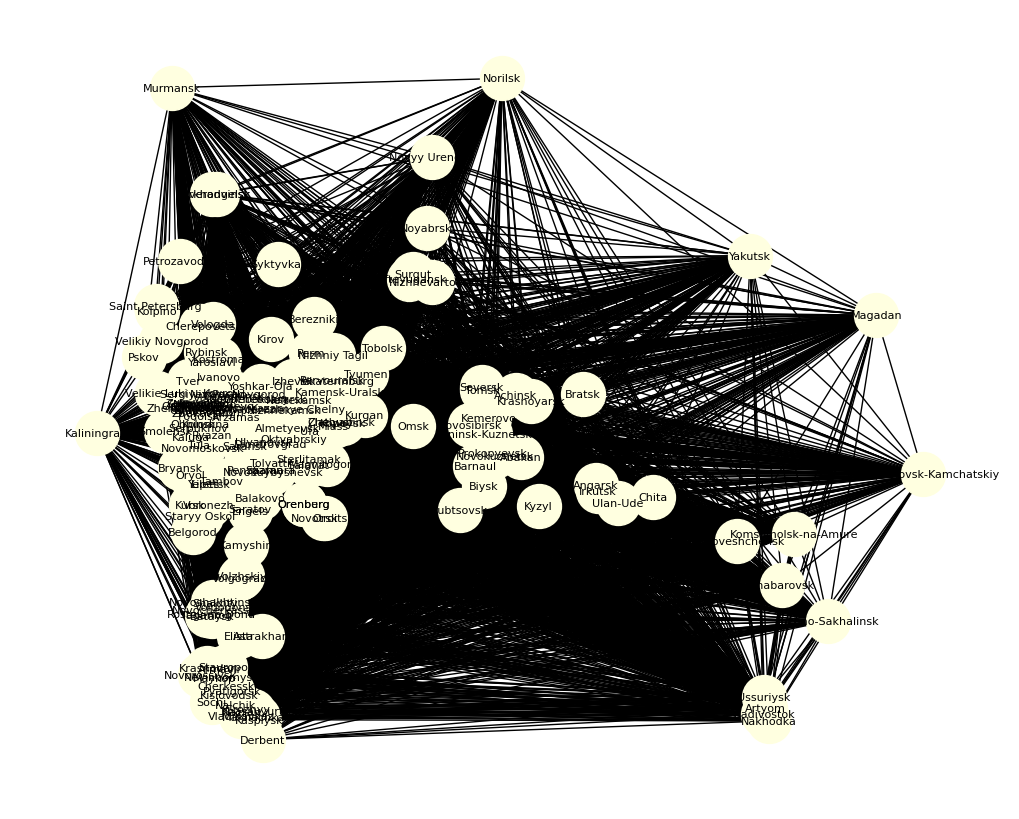

In [43]:
pos={city:(locations[city]['lon'],locations[city]['lat']) for city in locations}
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=1000, font_size=8)
plt.show()

In [9]:
def print_path(chemin,problem, title):
    G = nx.Graph()
    for i in range(len(chemin) - 1):
        city1 = chemin[i]
        city2 = chemin[i + 1]
        distance = calculate_distance(problem.locations[city1],problem.locations[city2])
        G.add_edge(city1, city2, weight=distance)
    G.add_edge(chemin[-1], chemin[0], weight=calculate_distance(problem.locations[ chemin[-1]],problem.locations[chemin[0]]))
    pos = {city: (locations[city]['lon'], locations[city]['lat']) for city in chemin}
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightpink', node_size=500, font_size=7)
    plt.title(title)
    plt.show()

In [10]:
class TSP_problem:
    def __init__(self, locations):
        self.locations = locations
        self.cities=list(locations.keys())
        self.number_cities=len(self.cities)
        self.initial = self.random_solution()

    def random_solution(self):
        return random.sample(self.cities[:],self.number_cities)

    @counter
    def value(self,state):
        cost = 0
        for i in range(len(state)-1):
            cost+=calculate_distance(self.locations[state[i]],self.locations[state[i+1]])
        cost += calculate_distance(self.locations[state[0]],self.locations[state[-1]])
        return cost

    def neighbour(self, state):#two_opt
        """ Neighbour generating function for Traveling Salesman Problem
        This function generates a neighbour state by reversing part of the path
        """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

## Ant Colony Optimization

In [15]:
def Next_city( distances,current_city, visited,pheromones):
  probabilities=[]
  total_prob=0
  for city in distances[current_city].keys():
    if city not in visited:
      prob=pheromones[current_city][city]/(distances[current_city][city]**2)
      probabilities.append((city,prob))
      total_prob+=prob
  probabilities=[(city, prob/total_prob) for city, prob in probabilities]  #We normalize the probablity
  return random.choices([pair[0] for pair in probabilities], weights=[pair[1] for pair in probabilities])[0]

In [64]:
def AntColony(distances,evaporation_rate=0.5, number_of_ants=20, max_iterations=100):
    fit_list=[]
    best_solution = None
    best_value = float('inf')
    pheromones = {}
    for city1 in distances.keys():
      pheromones[city1] = {}
      for city2 in distances[city1].keys():
        pheromones[city1][city2] = 1.0
    for iteration in range(max_iterations):
        iteration_solutions=[]
        for ant in range(number_of_ants):
            total_cost=0
            current_city=random.choice(list(distances.keys()))
            current_solution=[current_city]
            visited=set(current_solution)
            while len(visited) < len(distances):
                next_city=Next_city(distances,current_city, visited,pheromones)
                current_solution.append(next_city)
                visited.add(next_city)
                total_cost+=distances[current_city][next_city]
                current_city=next_city
            total_cost+=distances[current_city][current_solution[0]]
            iteration_solutions.append((current_solution, total_cost))
            if total_cost<best_value:
                best_solution=current_solution
                best_value=total_cost
        for city1 in pheromones.keys():
            for city2 in pheromones[city1].keys():
                pheromones[city1][city2]*=(1-evaporation_rate)
        for solution,cost in iteration_solutions:
            for i in range(len(solution)-1):
                pheromones[solution[i]][solution[i+1]]+=1.0/cost
            pheromones[solution[-1]][solution[0]]+=1.0/cost
        for i in range(len(best_solution)-1):
              pheromones[best_solution[i]][best_solution[i+1]]+=1.0/best_value
        pheromones[best_solution[-1]][best_solution[0]]+=1.0/best_value
        fit_list.append(best_value)
    return best_solution, best_value,fit_list

In [65]:
best_solution, best_value,fit_list=AntColony(distances,max_iterations=100)
print(f"Best solution found has cost: {best_value}")

Best solution found has cost: 38877.2188738559


In [57]:
best_solution, best_value,fit_list=AntColony(distances,max_iterations=100)
print(f"Best solution found has cost: {best_value}")

Best solution found has cost: 37520.43929450585


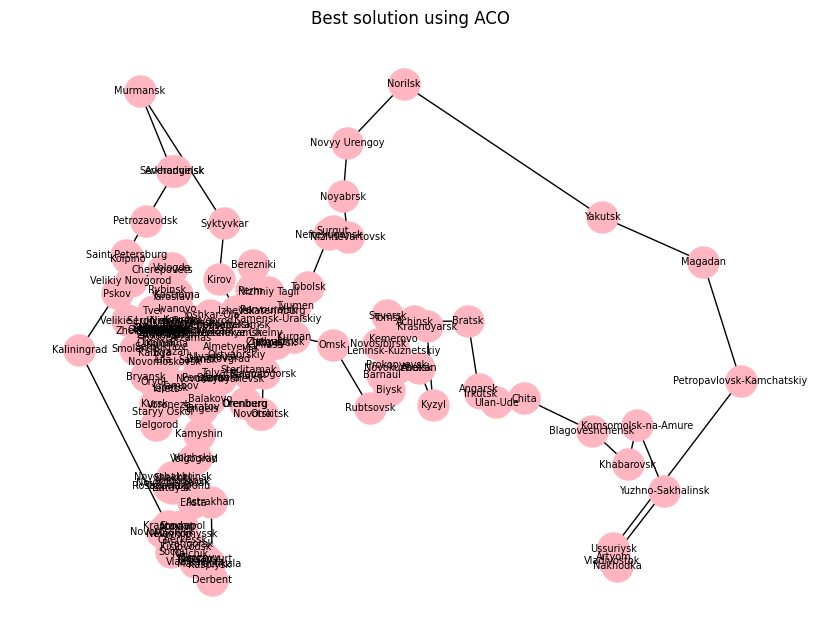

In [58]:
print_path(best_solution, problem, title="Best solution using ACO")

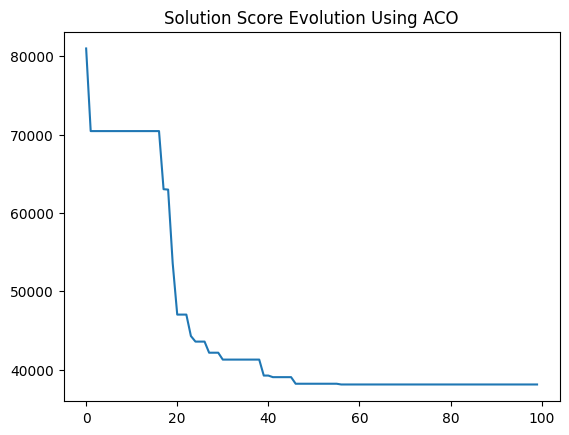

In [63]:
plt.plot(fit_list)
plt.title("Solution Score Evolution Using ACO")
plt.show()